In [177]:
import networkx as nx
import numpy as np
import random
import os
import os
from shutil import copyfile
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Lucida Grande']


data_name = "modified-morPOP-NL-day20" #HI-II-14, Digg
experiment_types = ["CN", "R0", 'GCC']
step_ratio = 0.01
cost_types = ['degree']

In [245]:
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator

class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)


In [178]:
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


In [179]:
import matplotlib

In [138]:
font = {
        'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)

In [139]:
def make_dir(path):
    try: os.makedirs(path)
    except: return -1

In [181]:
#network_file_name = "{}".format(data_name)
network_file_path = "./data/real/{}.txt".format(data_name)
G = nx.read_edgelist(network_file_path, nodetype=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

_g_num_nodes = G.number_of_nodes()
_CN_denom = (((_g_num_nodes * (_g_num_nodes - 1))) /2) #total possible pariwise connectivity
_k_node_removals = int(_g_num_nodes * step_ratio)
print("Node removals per iteration: ", _k_node_removals)
print("Total possible pairwise connectivity", int(_CN_denom))


def calc_weighted_avg(arr):
    w_arr = np.zeros(arr.shape)
    unique, counts = np.unique(arr, return_counts=True)
    freq_dict = dict(zip(unique,counts))
    for i in range(len(arr)):
        w_arr[i] = freq_dict[arr[i]]
    return np.average(arr, weights=w_arr)

def calc_graph_connectivity(G, experiment_type, T=1):
    if(G.number_of_nodes() in [0, 1]): return 0
    if(experiment_type=="CN"):
        pairwise_connectivity = 0
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / _CN_denom
        return pc
    elif(experiment_type=="R0"):
        #get gcc
        gcc_nodes = max(nx.connected_components(G), key=len)
        G = G.subgraph(gcc_nodes)
        
        degree_array = np.array(list(dict(nx.degree(G)).values()))
        square_degree_array = degree_array**2

        denom = calc_weighted_avg(degree_array)
        if(denom == 0):
            R_0 = 0
        else:
            R_0 = round(T * ((calc_weighted_avg(square_degree_array)/denom) - 1), 2)
        return R_0
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        #print(maxCC , _g_num_nodes)
        #return maxCC / _g_num_nodes
        return maxCC

Number of nodes in the graph: 507503
Number of edges in the graph: 3269669
Node removals per iteration:  5075
Total possible pairwise connectivity 128779393753


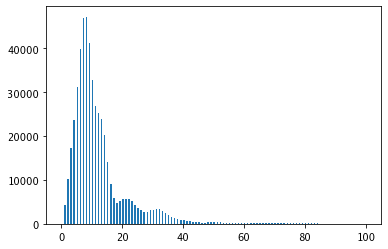

In [ ]:
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=200, range=[0, 100])
    plt.show()

plot_degree_dist(G)

In [182]:
# high degree adaptive
def AdaptiveBaselines(G, k=_k_node_removals,approach='HDA', write=False, experiment_types=experiment_types):
    scores_dict = {}
    for e_t in experiment_types: scores_dict[e_t] = [calc_graph_connectivity(G, experiment_type=e_t)]


    print("{} for k: {}".format(approach, k))

    while(True):
        print("- ", end="")
        if(approach=='HDA'):
            node_scores = dict(G.degree)
        node_scores_sorted = list(sorted(node_scores.items(), key=lambda item: item[1], reverse=True))
        isTerminal = k > len(node_scores_sorted)

        num_removals = int(min(k, len(node_scores_sorted)))
        node_score_pairs = node_scores_sorted[0:num_removals]
        node_removals = [i[0] for i in node_score_pairs]

        G.remove_nodes_from(node_removals)

        for e_t in experiment_types: scores_dict[e_t].append(calc_graph_connectivity(G, experiment_type=e_t))


        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])
        print("\t-Finished export")

    return scores_dict

In [183]:
def calc_score_from_nodes_file(G, node_files, export_path, k=_k_node_removals, write=False, experiment_types=experiment_types):
    scores_dict = {}
    for e_t in experiment_types: scores_dict[e_t] = [calc_graph_connectivity(G, experiment_type=e_t)]

    f = open(node_files,'r')
    node_removals = []
    for node in f:
        node_removals.append(int(node))
    #print(node_removals)    
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")
        G.remove_nodes_from(curr_node_removals)

        for e_t in experiment_types: scores_dict[e_t].append(calc_graph_connectivity(G, experiment_type=e_t))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return scores_dict

In [184]:
def calc_CI_score(G, solution_file, k=_k_node_removals, write=False, experiment_types=experiment_types):
  k = int(k)
  scores_dict = {}
  for e_t in experiment_types: scores_dict[e_t] = [calc_graph_connectivity(G, experiment_type=e_t)]

  f = open(solution_file,'r')
  node_removals = []
  for idx, line in enumerate(f.readlines()):
    nodes_line = line.split(",")[1:]
    node_removals = node_removals + nodes_line

  temp_l = []
  for n in node_removals:
    try:
      temp_l.append(int(n))
    except:
      pass
  node_removals = temp_l
  #node_removals = [int(n) for n in node_removals if n != ""]
  print("Len solution: {}".format(len(node_removals)))

  while(True):
    print("{}- ".format(G.number_of_nodes()), end="")

    isTerminal = k > len(node_removals)
    
    num_removals = int(min(k, len(node_removals)))
    curr_node_removals = node_removals[0:num_removals]

    G.remove_nodes_from(curr_node_removals)

    for e_t in experiment_types: scores_dict[e_t].append(calc_graph_connectivity(G, experiment_type=e_t))

    node_removals = node_removals[num_removals:]
    if(isTerminal): break

  print("\t-Finished calculations")
  if(write):
    result_file = os.path.join(CI_export_path, "scores_{}.txt".format(k))
    with open(result_file, 'w') as f_out:
            for j in range(len(pairwise_conn_list)):
                f_out.write('%.8f\n' % pairwise_conn_list[j])

    print("\t-Finished export")


  return scores_dict


In [185]:
G = nx.read_edgelist(network_file_path, nodetype=int)

In [186]:
%%time
HDA_scores_dict = AdaptiveBaselines(G, k=_k_node_removals, approach='HDA')

HDA for k: 5075
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
CPU times: user 7min 21s, sys: 4.28 s, total: 7min 25s
Wall time: 7min 26s


In [187]:
HDA_scores_dict.keys()

dict_keys(['CN', 'R0', 'GCC'])

In [188]:
exp_dict = {
            "HDA":{'label': "HDA", 'CN': HDA_scores_dict['CN'], 'R0': HDA_scores_dict['R0'], 'GCC': HDA_scores_dict['GCC'], 'shape':"--"}, 
            "old_FINDER_CN_tf":{"label": "Pre-trained TF FINDER (BA graphs)", 'shape': "-->"},
            "my_FINDER_CN_tf":{"label": "New TF FINDER (BA graphs)", 'shape': "-p"},
            "FINDER_CN":{"label": "Torch FINDER (BA graphs)", 'shape': "-+"},
            "CI":{"label": "Collective influence", 'shape': "*-"}
           }


In [189]:
# CI baseline
comma_file_name = "comma-modified-morPOP-NL-day20"
comma_network_file_path = "./data/real/{}.txt".format(comma_file_name)

G = nx.read_edgelist(comma_network_file_path, delimiter="," , nodetype=int)
CI_solution_file = "./data/real/{}.txt_out".format(comma_file_name)

CI_scores_dict = calc_CI_score(G, CI_solution_file, k=_k_node_removals)

exp_dict["CI"]['CN'] = CI_scores_dict['CN']
exp_dict["CI"]['R0'] = CI_scores_dict['R0']
exp_dict["CI"]['GCC'] = CI_scores_dict['GCC']

Len solution: 507503
507503- 502428- 497353- 492278- 487203- 482128- 477053- 471978- 466903- 461828- 456753- 451678- 446603- 441528- 436453- 431378- 426303- 421228- 416153- 411078- 406003- 400928- 395853- 390778- 385703- 380628- 375553- 370478- 365403- 360328- 355253- 350178- 345103- 340028- 334953- 329878- 324803- 319728- 314653- 309578- 304503- 299428- 294353- 289278- 284203- 279128- 274053- 268978- 263903- 258828- 253753- 248678- 243603- 238528- 233453- 228378- 223303- 218228- 213153- 208078- 203003- 197928- 192853- 187778- 182703- 177628- 172553- 167478- 162403- 157328- 152253- 147178- 142103- 137028- 131953- 126878- 121803- 116728- 111653- 106578- 101503- 96428- 91353- 86278- 81203- 76128- 71053- 65978- 60903- 55828- 50753- 45678- 40603- 35528- 30453- 25378- 20303- 15228- 10153- 5078- 3- 	-Finished calculations


In [190]:
#%%capture cap --no-stderr
result_folders = ['old_FINDER_CN_tf', 'my_FINDER_CN_tf', 'FINDER_CN', ]
#result_folders = ['FINDER_CN', ]
for r_f in result_folders:
    G = nx.read_edgelist(network_file_path, nodetype=int)

    FINDER_torch_file_path = os.path.join(".", "code", "results", r_f, 'real', 'StepRatio_0.0100',\
                            '{}.txt'.format(data_name))

    
    curr_sccores_dict = calc_score_from_nodes_file(G, FINDER_torch_file_path, None, k=_k_node_removals, write=False)
    #print("======", calc_graph_connectivity(_G))
    exp_dict[r_f]['CN'] = curr_sccores_dict['CN']
    exp_dict[r_f]['R0'] = curr_sccores_dict['R0']
    exp_dict[r_f]['GCC'] = curr_sccores_dict['GCC']

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations


In [160]:
#with open('FINDER_CN_out.txt', 'w') as f:
#    f.write(cap.stdout)

In [191]:
import matplotlib.ticker as ticker


/var/folders/_t/ycs1gv8s5433r_f6cdcw7ny40000gn/T/ipykernel_94469/1029903826.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


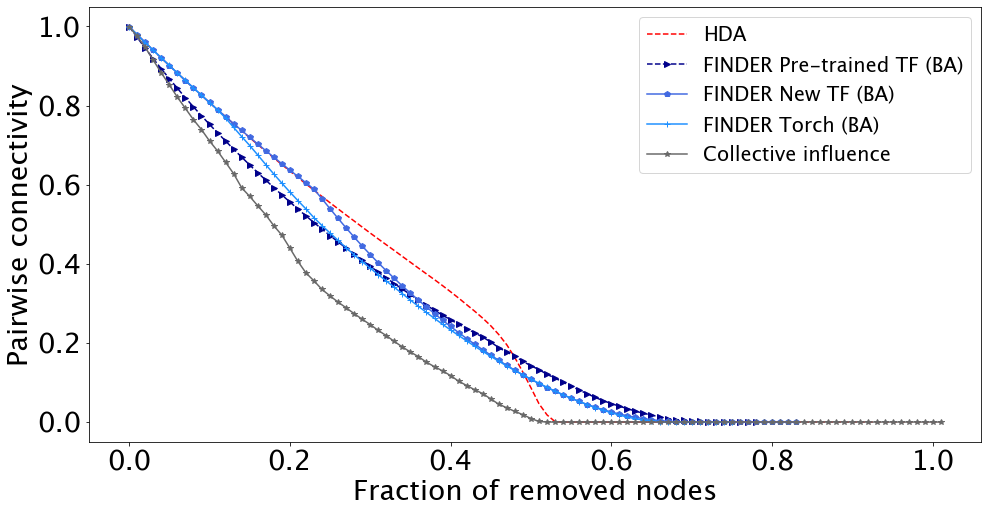

/var/folders/_t/ycs1gv8s5433r_f6cdcw7ny40000gn/T/ipykernel_94469/1029903826.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


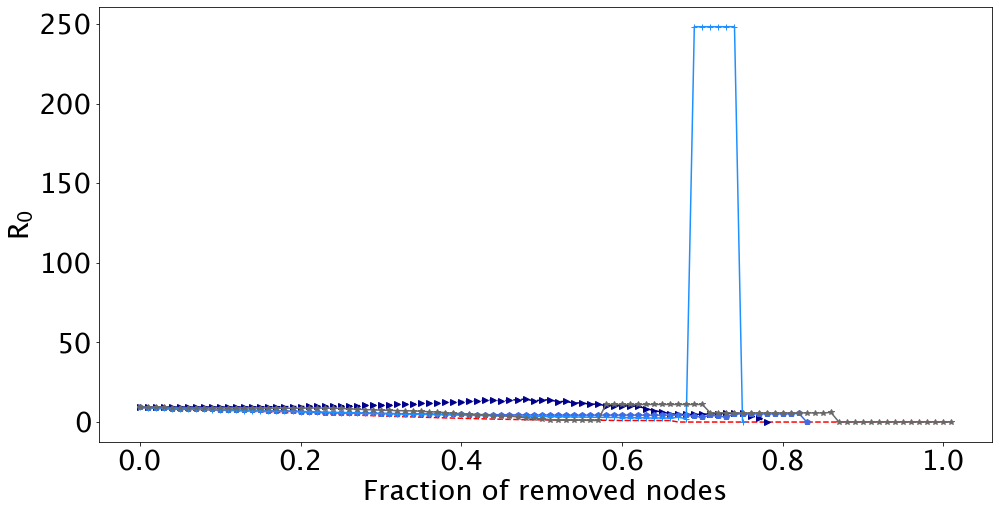

/var/folders/_t/ycs1gv8s5433r_f6cdcw7ny40000gn/T/ipykernel_94469/1029903826.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks)


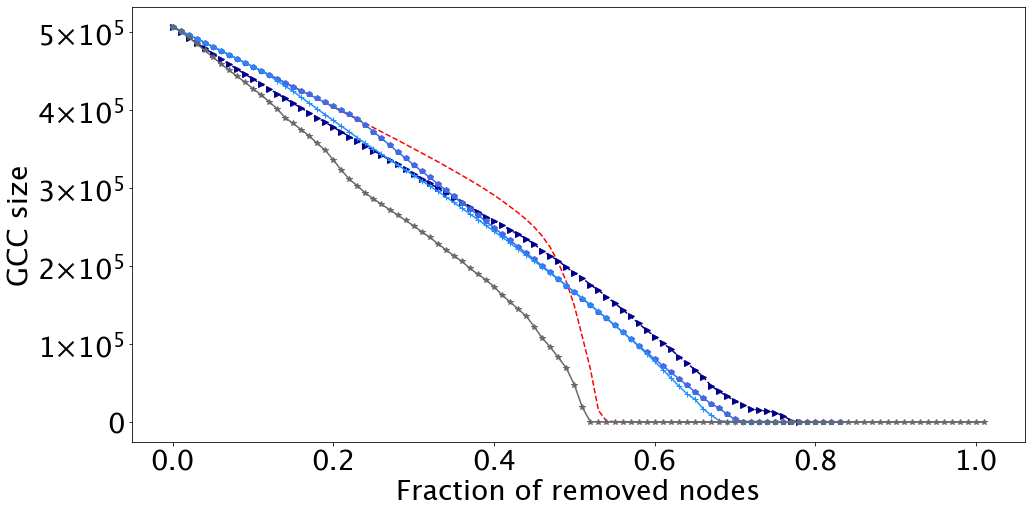

In [264]:
labels_et = {            "HDA":{'label': "HDA", 'shape':"--", 'color': 'red'}, 
            "old_FINDER_CN_tf":{"label": "FINDER Pre-trained TF (BA)", 'shape': "-->", 'color': 'darkblue'},
            "my_FINDER_CN_tf":{"label": "FINDER New TF (BA)", 'shape': "-p", 'color': 'royalblue'},
            "FINDER_CN":{"label": "FINDER Torch (BA)", 'shape': "-+", 'color': 'dodgerblue'},
            "CI":{"label": "Collective influence", 'shape': "*-", 'color': 'dimgray'}
}

for e_t in experiment_types:
    fig, ax = plt.subplots(figsize=(16,8))

    #plt.plot(CN_scores, label='CN')
    for key in exp_dict.keys():
        
        if(key != 'jjFINDER_CN'):
            ax.plot(exp_dict[key][e_t], exp_dict[key]['shape'], label=labels_et[key]['label'],color=labels_et[key]['color'])
        
    #plt.plot(CI_scores, label='CI')
    ax.legend()
    #plt.xlabel("# iterations of {} node removals".format(_k_node_removals))
    plt.xlabel("Fraction of removed nodes")
    #plt.xticks([str(s) for s in [0, 0.2, 0.4, 0.6, 0.8, 1]])

    #plt.ylabel("Graph connectivity {}".format(e_t))
    ticks = ax.get_xticks()*0.01
    ax.set_xticklabels(ticks)

    if(e_t == 'CN'):
        plt.ylabel("Pairwise connectivity")
        plt.legend(loc=1, prop={'size': 20})

    if(e_t == "R0"):
        plt.ylabel("$R_0$")
        #ax.set_yticks([0,5,10,15])
        #ax.set_ylim(0, 17.5)
        plt.legend(loc=2, prop={'size': 20})
        plt.legend().remove()


    if(e_t == "GCC"):
        plt.ylabel("GCC size")
        #plt.ticklabel_format( axis='y', style='sci', scilimits=(0,0))
        plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.e"))

        plt.legend(loc=1, prop={'size': 20})
        plt.legend().remove()



    #plt.savefig('figures/NOSPIKE-uncosted_compare_{}.pdf'.format(e_t))  
    plt.savefig('figures/uncosted_compare_{}.pdf'.format(e_t))  

    plt.show()


## Costed analysis


In [218]:
data_name = "modified-morPOP-NL-day20.txt"
experiment_types = ["CN", "R0", 'GCC']


In [219]:
network_file_name = "{}_degree".format(data_name)
network_file_path = "./data/real/cost/{}.gml".format(network_file_name)
G = nx.read_gml(network_file_path, destringizer=int)
print("Number of nodes in the graph:", G.number_of_nodes())
print("Number of edges in the graph:", G.number_of_edges())

_g_num_nodes = G.number_of_nodes()
_CN_denom = (((_g_num_nodes * (_g_num_nodes - 1))) /2)
_k_node_removals = int(_g_num_nodes * step_ratio)

print(_g_num_nodes)
def calc_graph_connectivity(G, experiment_type, T=1):
    if(G.number_of_nodes() in [0, 1]): return 0
    if(experiment_type=="CN"):
        pairwise_connectivity = 0
        for i in list(nx.connected_components(G)): pairwise_connectivity += (len(i) * (len(i) -1)) / 2
        pc = pairwise_connectivity / _CN_denom
        return pc
    elif(experiment_type=="R0"):
        #get gcc
        gcc_nodes = max(nx.connected_components(G), key=len)
        G = G.subgraph(gcc_nodes)
        
        degree_array = np.array(list(dict(nx.degree(G)).values()))
        square_degree_array = degree_array**2

        denom = calc_weighted_avg(degree_array)
        if(denom == 0):
            R_0 = 0
        else:
            R_0 = round(T * ((calc_weighted_avg(square_degree_array)/denom) - 1), 2)
        return R_0
    else:
        maxCC = len(max(nx.connected_components(G), key=len))
        #print(maxCC , _g_num_nodes)
        #return maxCC / _g_num_nodes
        return maxCC

Number of nodes in the graph: 507503
Number of edges in the graph: 3269669
507503


In [220]:
SUM_COST = 0
for i in range(len(G.nodes())):
    SUM_COST += G.nodes[i]['weight']

print(SUM_COST)

10014.300153147547


In [221]:
max_cost = 0
for i in range(len(G.nodes())):
    curr_cost = G.nodes[i]['weight']
    if(curr_cost > max_cost): max_cost = curr_cost

print(max_cost)

1.0


In [222]:
#  adaptive baselines
def cost_AdaptiveBaselines(G, k=_k_node_removals, approach='HDA', write=False):
    cost_list = [0]
    scores_dict = {}
    for e_t in experiment_types: scores_dict[e_t] = [calc_graph_connectivity(G, experiment_type=e_t)]

    print("{} for k: {}".format(approach, k))
    print(experiment_types)

    while(True):
        print("- ", end="")
        if(approach=='HDA'):
            node_scores = dict(G.degree)

        node_scores_sorted = list(sorted(node_scores.items(), key=lambda item: item[1], reverse=True))
        isTerminal = k > len(node_scores_sorted)

        num_removals = int(min(k, len(node_scores_sorted)))
        node_score_pairs = node_scores_sorted[0:num_removals]
        node_removals = [i[0] for i in node_score_pairs]

        curr_cost = cost_list[-1]
        for n in node_removals:
            curr_cost += G.nodes[n]['weight']
        
        cost_list.append(curr_cost)

        G.remove_nodes_from(node_removals)

        for e_t in experiment_types: scores_dict[e_t].append(calc_graph_connectivity(G, experiment_type=e_t))

        if(isTerminal): break

    print("\t-Finished calculations")

    if(write):
        result_file = os.path.join(HDA_export_path, "{}_scores_k_{}.txt".format(data_name, k))
        with open(result_file, 'w') as f_out:
                for j in range(len(connectivity_scores_list)):
                    f_out.write('%.8f\n' % connectivity_scores_list[j])
        print("\t-Finished export")

    return scores_dict, cost_list

In [223]:
def cost_calc_score_from_nodes_file(G, node_files, export_path, k=_k_node_removals, write=False):
    cost_list = [0]
    scores_dict = {}
    for e_t in experiment_types: scores_dict[e_t] = [calc_graph_connectivity(G, experiment_type=e_t)]

    f = open(node_files,'r')
    node_removals = []
    for node in f:
        node_removals.append(int(node))

    
    while(True):
        print("- ", end="")

        isTerminal = k > len(node_removals)

        num_removals = int(min(k, len(node_removals)))
        curr_node_removals = node_removals[0:num_removals]
        #print(curr_node_removals)
        #print("=======")

        curr_cost = cost_list[-1]
        for n in curr_node_removals:
            curr_cost += G.nodes[n]['weight']
        
        cost_list.append(curr_cost)

        G.remove_nodes_from(curr_node_removals)

        for e_t in experiment_types: scores_dict[e_t].append(calc_graph_connectivity(G, experiment_type=e_t))

        node_removals = node_removals[num_removals:]
        if(isTerminal): break

    print("\t-Finished calculations")
    if(write):
        result_file = os.path.join(export_path, "scores_k_{}.txt".format(k))
        with open(result_file, 'w') as f_out:
                for j in range(len(pairwise_conn_list)):
                    f_out.write('%.8f\n' % pairwise_conn_list[j])

        print("\t-Finished export")


    return scores_dict, cost_list

In [224]:
ORIG_G = nx.read_gml(network_file_path, destringizer=int)

In [225]:
G = ORIG_G.copy()

In [226]:
%%time
HDA_scores_dict, HDA_costs = cost_AdaptiveBaselines(G, k=_k_node_removals,approach='HDA', write=False)


HDA for k: 5075
['CN', 'R0', 'GCC']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
CPU times: user 6min 14s, sys: 3.55 s, total: 6min 18s
Wall time: 6min 19s


In [227]:
for i in range(len(HDA_costs)): HDA_costs[i] =  HDA_costs[i]/SUM_COST

In [228]:
cost_exp_dict = {
            "HDA":{'label': "HDA", 'CN': [HDA_costs,HDA_scores_dict['CN']], 'R0': [HDA_costs,HDA_scores_dict['R0']], 'GCC': [HDA_costs,HDA_scores_dict['GCC']], 'shape':"--"}, 
            "old_FINDER_CN_cost_tf":{"label": "Pre-trained TF cost FINDER (BA graphs)", 'shape': "-->"},
            "my_FINDER_CN_cost_tf":{"label": "New TF cost FINDER (BA graphs)", 'shape': "-p"},
            "my_FINDER_CN_cost_tf_small-world":{'label': 'New TF cost FINDER (small world graphs)', 'shape':'-d'},
            "FINDER_CN_cost":{"label": "Torch cost FINDER (BA graphs)", 'shape': "-+"},
            "CI":{"label": "Collective influence", 'shape': "*-"}
           }


In [231]:
result_folders = ['old_FINDER_CN_cost_tf', 'my_FINDER_CN_cost_tf',
                  'my_FINDER_CN_cost_tf_small-world','FINDER_CN_cost', ]

for weight_type in ['degree']:
    for r_f in result_folders:
        network_file_name = "{}_{}".format(data_name, weight_type)

        torch_FINDER_nodefile_degree_scores = None
        FINDER_torch_file_path = os.path.join(".", "code", "results", r_f, 'real', 'Data_{}'.format(weight_type),\
                                    'StepRatio_0.0100', '{}.txt'.format(network_file_name))

        G = ORIG_G.copy()

        curr_sccores_dict, curr_costs = cost_calc_score_from_nodes_file(G, FINDER_torch_file_path, None, k=_k_node_removals, write=False)
        for i in range(len(curr_costs)): curr_costs[i] =  curr_costs[i]/SUM_COST
        cost_exp_dict[r_f]['CN'] = [curr_costs, curr_sccores_dict['CN']]
        cost_exp_dict[r_f]['R0'] = [curr_costs, curr_sccores_dict['R0']]
        cost_exp_dict[r_f]['GCC'] = [curr_costs, curr_sccores_dict['GCC']]



- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 	-Finished calculations


In [232]:
comma_file_name = "comma-modified-morPOP-NL-day20"
comma_network_file_path = "./data/real/{}.txt".format(comma_file_name)
CI_solution_file = "./data/real/{}.txt_out".format(comma_file_name)

G = nx.read_edgelist(comma_network_file_path, delimiter="," , nodetype=int)

G_costed = add_cost_attr(G)

curr_sccores_dict, curr_costs = cost_calc_CI_score(G_costed, CI_solution_file, k=_k_node_removals)
for i in range(len(curr_costs)): curr_costs[i] =  curr_costs[i]/SUM_COST
cost_exp_dict['CI']['CN'] = [curr_costs, curr_sccores_dict['CN']]
cost_exp_dict['CI']['R0'] = [curr_costs, curr_sccores_dict['R0']]
cost_exp_dict['CI']['GCC'] = [curr_costs, curr_sccores_dict['GCC']]

Len solution: 507503
507503- 502428- 497353- 492278- 487203- 482128- 477053- 471978- 466903- 461828- 456753- 451678- 446603- 441528- 436453- 431378- 426303- 421228- 416153- 411078- 406003- 400928- 395853- 390778- 385703- 380628- 375553- 370478- 365403- 360328- 355253- 350178- 345103- 340028- 334953- 329878- 324803- 319728- 314653- 309578- 304503- 299428- 294353- 289278- 284203- 279128- 274053- 268978- 263903- 258828- 253753- 248678- 243603- 238528- 233453- 228378- 223303- 218228- 213153- 208078- 203003- 197928- 192853- 187778- 182703- 177628- 172553- 167478- 162403- 157328- 152253- 147178- 142103- 137028- 131953- 126878- 121803- 116728- 111653- 106578- 101503- 96428- 91353- 86278- 81203- 76128- 71053- 65978- 60903- 55828- 50753- 45678- 40603- 35528- 30453- 25378- 20303- 15228- 10153- 5078- 3- 	-Finished calculations


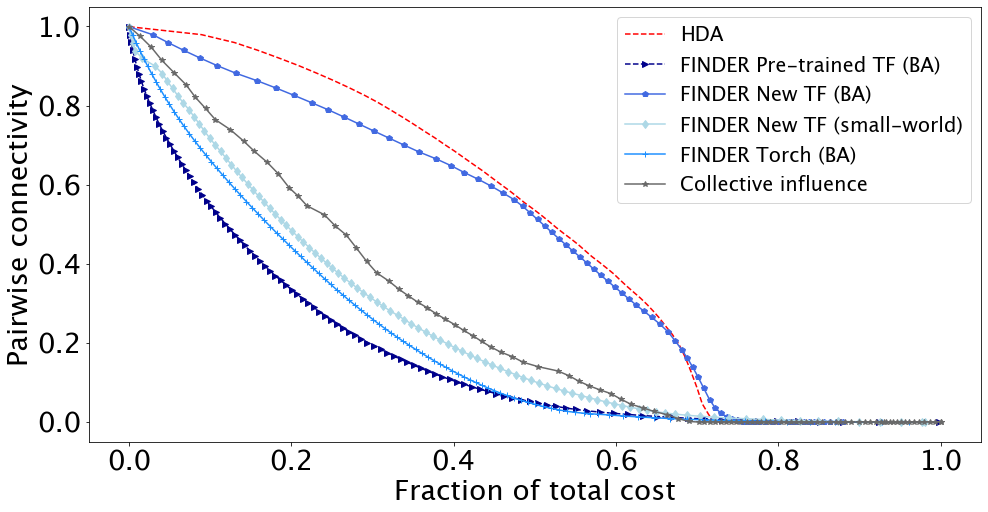

In [252]:

labels_et = {
            "HDA":{'label': "HDA", 'shape':"--", 'color': 'red'}, 
            "old_FINDER_CN_cost_tf":{"label": "FINDER Pre-trained TF (BA)", 'shape': "-->", 'color': 'darkblue'},
            "my_FINDER_CN_cost_tf":{"label": "FINDER New TF (BA)", 'shape': "-p", 'color': 'royalblue'},
            "my_FINDER_CN_cost_tf_small-world":{'label': 'FINDER New TF (small-world)', 'shape':'-d', 'color':'lightblue'},
            "FINDER_CN_cost":{"label": "FINDER Torch (BA)", 'shape': "-+",'color': 'dodgerblue'},
            "CI":{"label": "Collective influence", 'shape': "*-", 'color': 'dimgray'}
           }


plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    plt.plot(cost_exp_dict[key]['CN'][0], cost_exp_dict[key]['CN'][1],  labels_et[key]['shape'],
     label=labels_et[key]['label'], color=labels_et[key]['color'])

plt.legend()
plt.xlabel("Fraction of total cost")
plt.ylabel("Pairwise connectivity")
plt.legend(loc=1, prop={'size': 20})

plt.savefig('figures/costed_compare_CN.pdf')
plt.show()


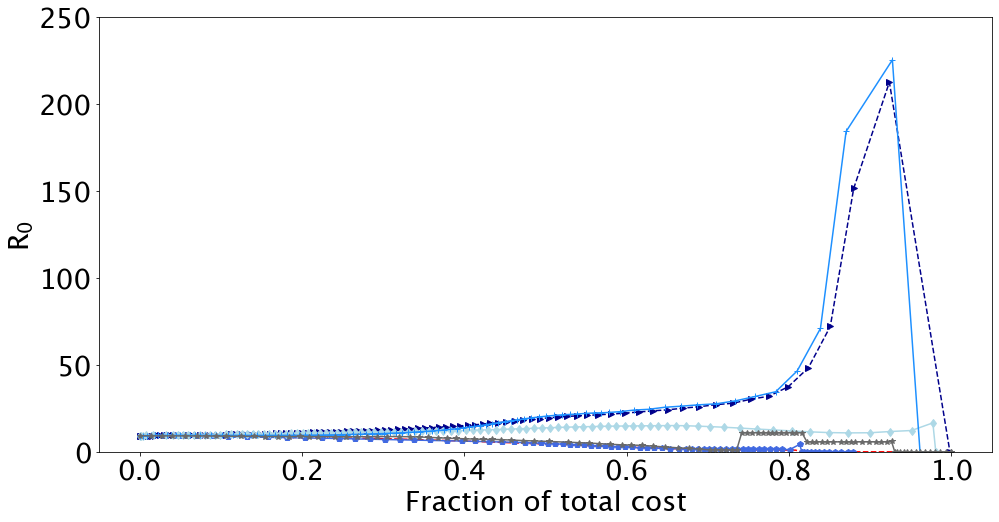

In [261]:


plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    plt.plot(cost_exp_dict[key]['R0'][0], cost_exp_dict[key]['R0'][1],  labels_et[key]['shape'],
     label=labels_et[key]['label'], color=labels_et[key]['color'])

plt.legend()
plt.xlabel("Fraction of total cost")
plt.ylabel(r"$R_0$")
plt.ylim(0, 250)
plt.legend(loc=2, prop={'size': 20})
plt.legend().remove()

plt.savefig('figures/costed_compare_R0.pdf')
plt.show()


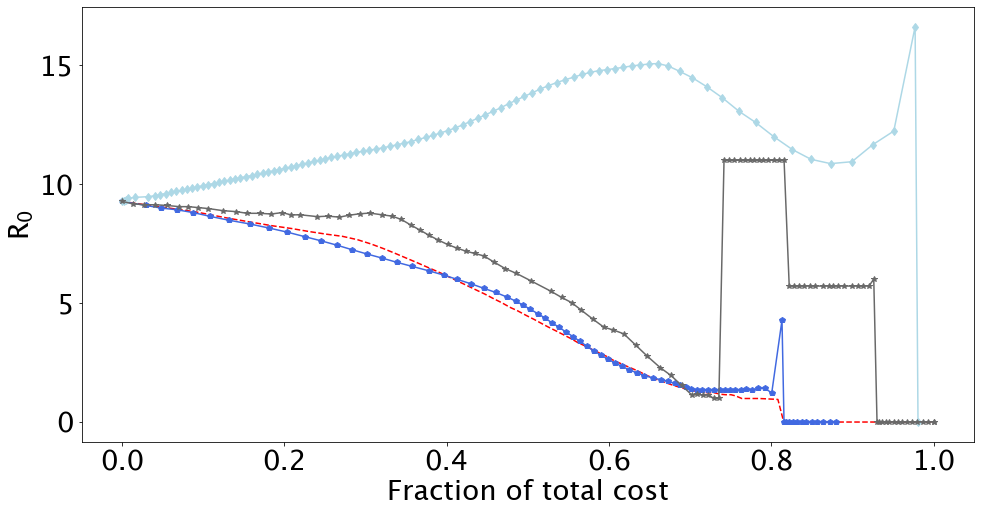

In [260]:
plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    if(key not in ['old_FINDER_CN_cost_tf', 'FINDER_CN_cost']):
        plt.plot(cost_exp_dict[key]['R0'][0], cost_exp_dict[key]['R0'][1],  labels_et[key]['shape'],
     label=labels_et[key]['label'], color=labels_et[key]['color'])

plt.legend()
plt.xlabel("Fraction of total cost")
plt.ylabel(r"$R_0$")
#plt.ylim(0, 250)
plt.legend(loc=2, prop={'size': 20})
plt.legend().remove()

plt.savefig('figures/NOSPIKE-costed_compare_R0.pdf')
plt.show()

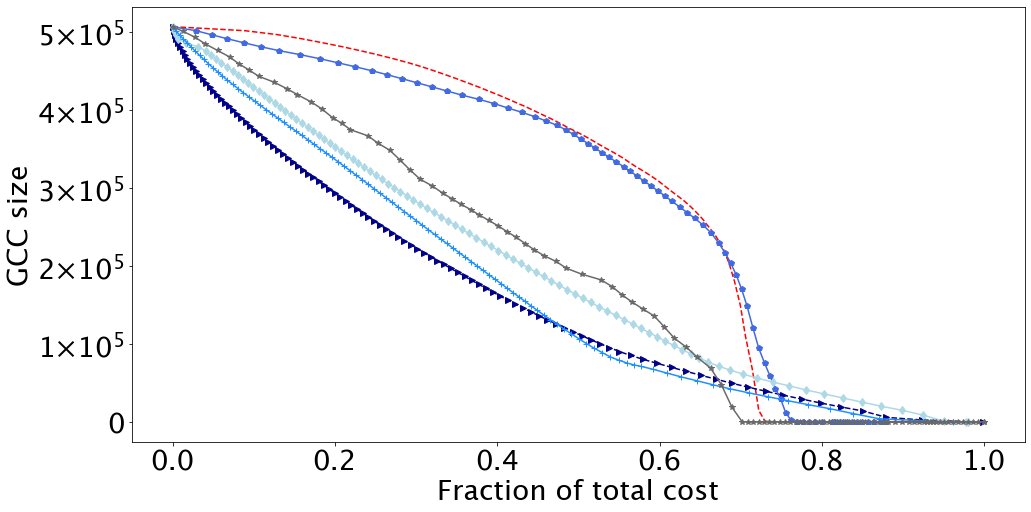

In [259]:
plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    plt.plot(cost_exp_dict[key]['GCC'][0], cost_exp_dict[key]['GCC'][1],  labels_et[key]['shape'],
     label=labels_et[key]['label'], color=labels_et[key]['color'])

plt.legend()
plt.xlabel("Fraction of total cost")
plt.ylabel(r"GCC size")
#plt.ylim(0, 250)
plt.gca().yaxis.set_major_formatter(MathTextSciFormatter("%1.e"))

plt.legend(loc=1, prop={'size': 20})
plt.legend().remove()

plt.savefig('figures/costed_compare_GCC.pdf')
plt.show()

In [265]:
def score_file_to_l(p):
    f = open(p,'r')
    scores = []
    for line in f:
        score = line.split(",")[0]
        scores.append(float(score))
    return scores


In [266]:
FINDER_code_path = os.path.join(".", "code")
torch_CN_train_curve_p = os.path.join(FINDER_code_path, 'FINDER_CN',
                                      'models', "truncNormal-TORCH-Model_barabasi_albert", 
                                      "ModelVC_30_50.csv")
torch_CN_train_curve = score_file_to_l(torch_CN_train_curve_p)

#----#
torch_CN_cost_train_curve_p = os.path.join(FINDER_code_path, 'FINDER_CN_cost',
                                           'models', "truncNormal-TORCH-Model_barabasi_albert",
                                           "ModelVC_30_50.csv")
torch_CN_cost_train_curve = score_file_to_l(torch_CN_cost_train_curve_p)
#----#

tf_CN_cost_train_curve_p_ba = os.path.join(FINDER_code_path, 'old_FINDER_CN_cost_tf',
                                           'models', "Model_barabasi_albert",
                                           "ModelVC_30_50.csv")
tf_CN_cost_train_curve_ba = score_file_to_l(tf_CN_cost_train_curve_p_ba)
#----#
tf_CN_cost_train_curve_p_sw = os.path.join(FINDER_code_path, 'old_FINDER_CN_cost_tf',
                                           'models', "Model_small-world",
                                           "ModelVC_30_50.csv")
tf_CN_cost_train_curve_sw = score_file_to_l(tf_CN_cost_train_curve_p_sw)
#----#

tf_CN_train_curve_p = os.path.join(FINDER_code_path, 'old_FINDER_CN_tf',
                                           'models', "Model_barabasi_albert",
                                           "ModelVC_30_50.csv")
tf_CN_train_curve = score_file_to_l(tf_CN_train_curve_p)


In [267]:
from matplotlib.ticker import StrMethodFormatter
max_iter = 400

/var/folders/_t/ycs1gv8s5433r_f6cdcw7ny40000gn/T/ipykernel_94469/2353317745.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','0', '$1x10^5$', '$2x10^5$'])


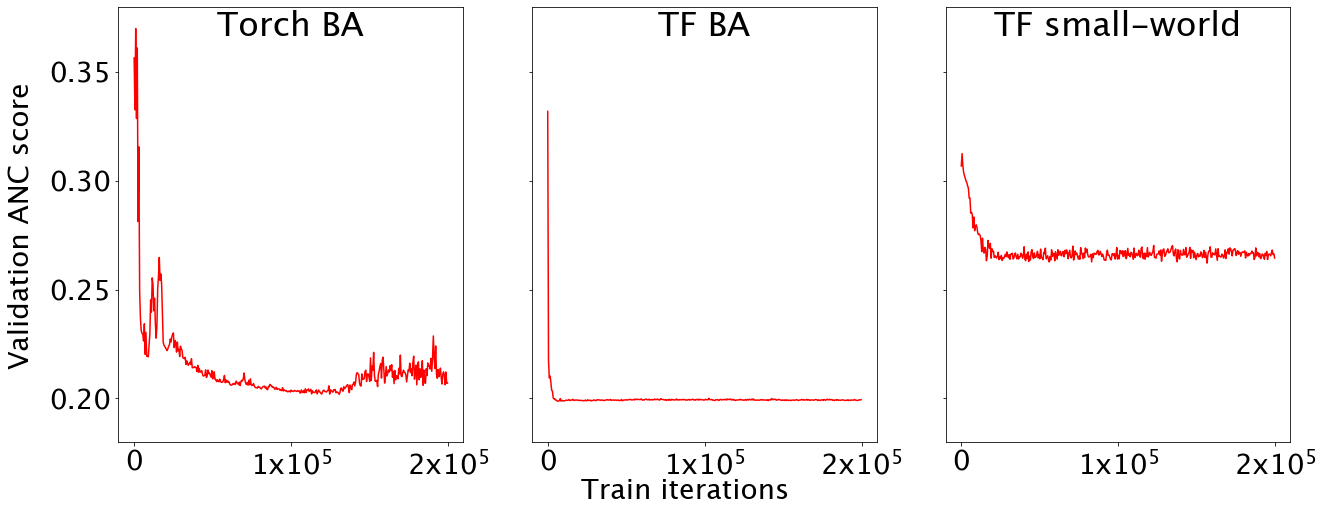

In [275]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21,8), sharey=True)
font_info = {'fontweight':'heavy', 'size':'x-large'}
#fig.suptitle('Training curve for CN costed\nY-axis score\nX-axis train iterations/500')
ax1.plot(torch_CN_cost_train_curve[:max_iter], 'red')
ax1.set_title('Torch BA', y=0.92)
ax2.plot(tf_CN_cost_train_curve_ba[:max_iter], 'red')
ax2.set_title('TF BA', y=0.92)
ax3.plot(tf_CN_cost_train_curve_sw[:max_iter], 'red')
ax3.set_title('TF small-world', y=0.92)
fig.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
ax1.set_yticks([0.20, 0.25, 0.30, 0.35])
ax1.set_ylim([0.18,0.38])
fig.text(0.5, 0.04, 'Train iterations', ha='center', va='center', )
fig.text(0.06, 0.5, 'Validation ANC score', ha='center', va='center', rotation='vertical', )

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(['0','0', '$1x10^5$', '$2x10^5$'])


fig.savefig("figures/train_CN_cost.pdf")


/var/folders/_t/ycs1gv8s5433r_f6cdcw7ny40000gn/T/ipykernel_94469/762254697.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','0', '$1x10^5$', '$2x10^5$'])


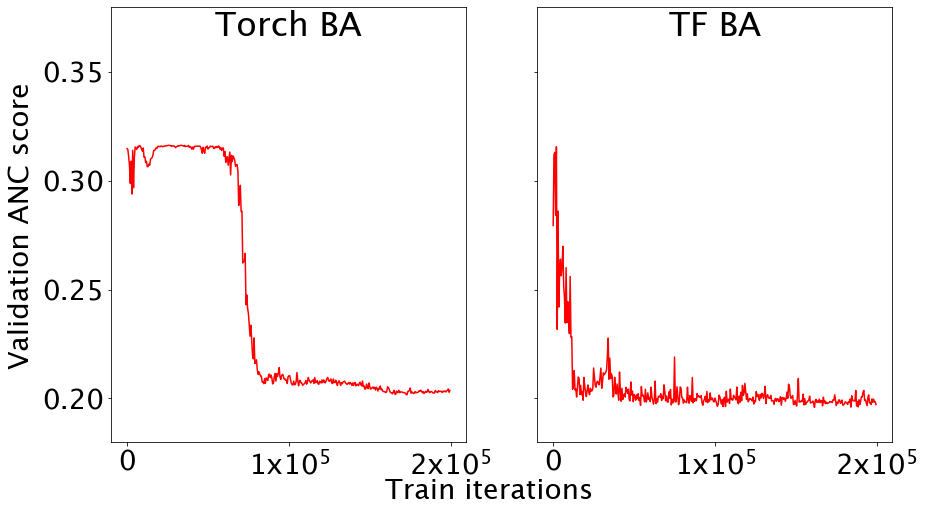

In [276]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8), sharey=True)
font_info = {'fontweight':'heavy', 'size':'x-large'}
#fig.suptitle('Training curve for CN un-costed\nY-axis score\nX-axis train iterations/500')
ax1.plot(torch_CN_train_curve[:max_iter], 'red')
ax1.set_title(label='Torch BA', y=0.92)
ax2.plot(tf_CN_train_curve[:max_iter], 'red')
ax2.set_title(label='TF BA', y=0.92)
ax1.set_yticks([0.20, 0.25, 0.30, 0.35])
ax1.set_ylim([0.18,0.38])

fig.text(0.5, 0.04, 'Train iterations', ha='center', va='center',)
fig.text(0.035, 0.5, 'Validation ANC score', ha='center', va='center', rotation='vertical',)

for ax in [ax1, ax2]:
    ax.set_xticklabels(['0','0', '$1x10^5$', '$2x10^5$'])

fig.savefig("figures/train_CN_uncost.pdf")


## Original reported curves

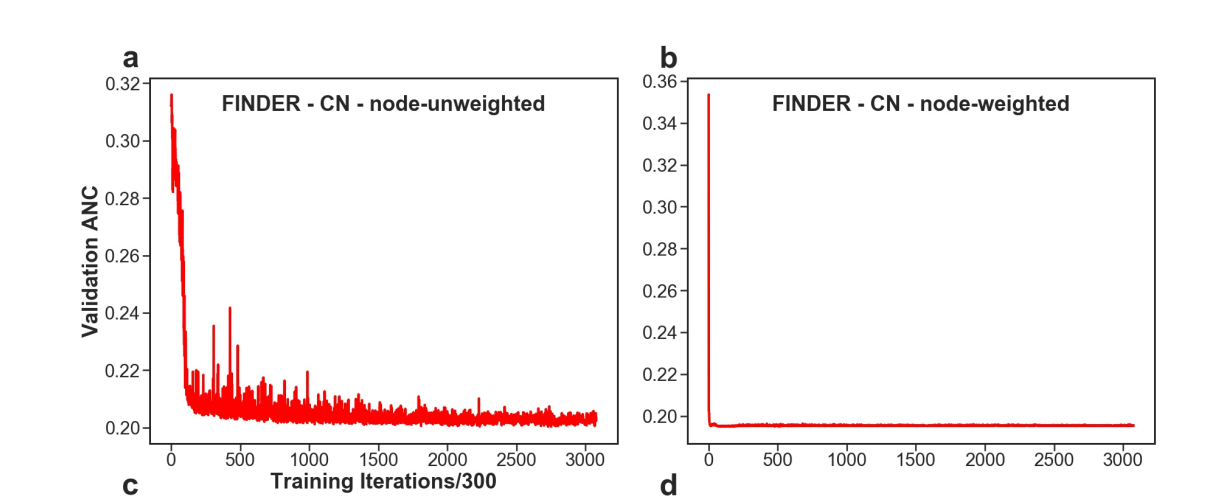

## Costed

Text(0, 0.5, 'Graph connectivity CN')

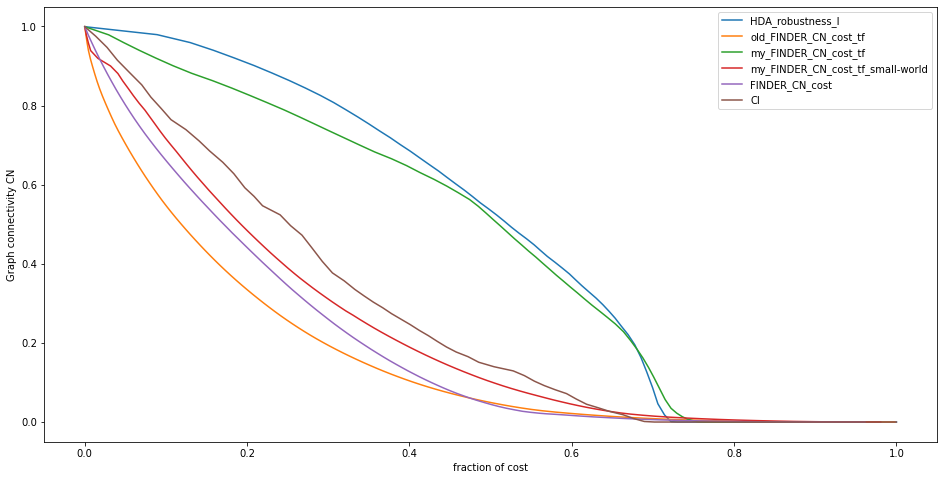

## un-Costed

Text(0, 0.5, 'Graph connectivity CN')

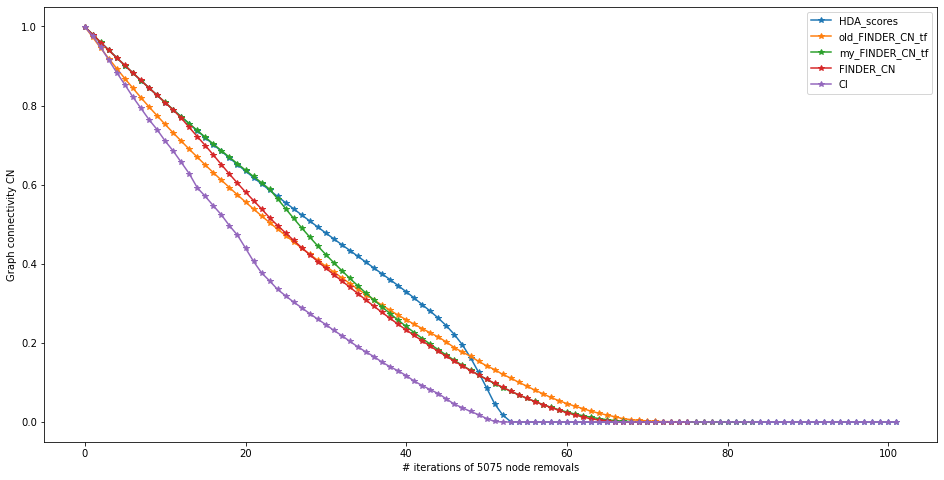

## Costed pure connectivity

Text(0, 0.5, 'Graph connectivity CN')

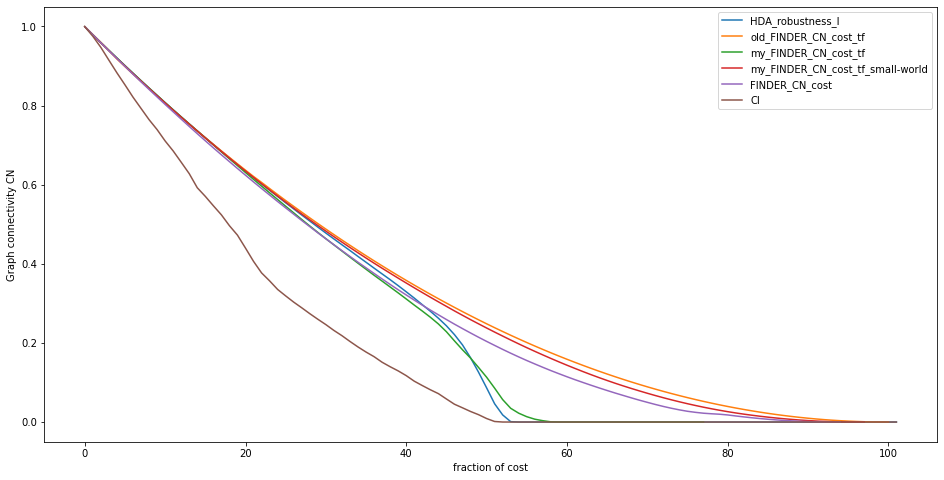

In [106]:


plt.figure(figsize=(16,8))

for key in cost_exp_dict.keys():
    plt.plot(cost_exp_dict[key][1], label=key)

plt.legend()
plt.xlabel("fraction of cost")
plt.ylabel("Graph connectivity {}".format(experiment_type))

In [105]:
def add_cost_attr(G, cost_type='degree'):
    nodes = G.nodes()
    nodes_l = list(nodes)
    nodes_l_map = map(int, nodes_l)
    nodes_l_int = list(nodes_l_map)
    nodes_l_int.sort()

    nodes_l_map = map(str, nodes_l_int)
    nodes_l = list(nodes_l_map)

    new_node_labels = {}
    for k in range(len(nodes_l)):
        new_node_labels[nodes_l[k]] = str(k)

    #g = nx.relabel_nodes(g, new_node_labels)

    ### degree weight
    if cost_type == 'degree':
        degree = nx.degree(G)
        maxDegree = max(dict(degree).values())
        weights = {}
        for node in G.nodes():
            weights[node] = degree[node] / maxDegree

    nx.set_node_attributes(G, weights, 'weight')

    return G


In [106]:
def cost_calc_CI_score(G, solution_file, k=_k_node_removals, write=False):
  k = int(k)
  #pairwise_conn_list = []
  scores_dict = {}
  cost_list = [0]
  for e_t in experiment_types: scores_dict[e_t] = [calc_graph_connectivity(G, experiment_type=e_t)]

  #pairwise_conn_list.append(calc_graph_connectivity(G, experiment_type='CN'))

  f = open(solution_file,'r')
  node_removals = []
  for idx, line in enumerate(f.readlines()):
    nodes_line = line.split(",")[1:]
    node_removals = node_removals + nodes_line

  temp_l = []
  for n in node_removals:
    try:
      temp_l.append(int(n))
    except:
      pass
  node_removals = temp_l
  #node_removals = [int(n) for n in node_removals if n != ""]
  print("Len solution: {}".format(len(node_removals)))

  while(True):
    print("{}- ".format(G.number_of_nodes()), end="")

    isTerminal = k > len(node_removals)
    
    num_removals = int(min(k, len(node_removals)))
    curr_node_removals = node_removals[0:num_removals]

    curr_cost = cost_list[-1]
    for n in curr_node_removals:
      curr_cost += G.nodes[n]['weight']
        
    cost_list.append(curr_cost)


    G.remove_nodes_from(curr_node_removals)

    for e_t in experiment_types: scores_dict[e_t].append(calc_graph_connectivity(G, experiment_type=e_t))

    node_removals = node_removals[num_removals:]
    if(isTerminal): break

  print("\t-Finished calculations")
  if(write):
    result_file = os.path.join(CI_export_path, "scores_{}.txt".format(k))
    with open(result_file, 'w') as f_out:
            for j in range(len(pairwise_conn_list)):
                f_out.write('%.8f\n' % pairwise_conn_list[j])

    print("\t-Finished export")


  return scores_dict, cost_list

In [105]:
G = nx.read_edgelist(network_file_path, delimiter="," , nodetype=int)
G_costed = add_cost_attr(G)

curr_sccores, curr_costs = cost_calc_CI_score(G_costed, CI_solution_file, k=_k_node_removals)
for i in range(len(curr_costs)): curr_costs[i] =  curr_costs[i]/SUM_COST
cost_exp_dict['CI'] = [curr_costs, curr_sccores]

Len solution: 507503
507503- 502428- 497353- 492278- 487203- 482128- 477053- 471978- 466903- 461828- 456753- 451678- 446603- 441528- 436453- 431378- 426303- 421228- 416153- 411078- 406003- 400928- 395853- 390778- 385703- 380628- 375553- 370478- 365403- 360328- 355253- 350178- 345103- 340028- 334953- 329878- 324803- 319728- 314653- 309578- 304503- 299428- 294353- 289278- 284203- 279128- 274053- 268978- 263903- 258828- 253753- 248678- 243603- 238528- 233453- 228378- 223303- 218228- 213153- 208078- 203003- 197928- 192853- 187778- 182703- 177628- 172553- 167478- 162403- 157328- 152253- 147178- 142103- 137028- 131953- 126878- 121803- 116728- 111653- 106578- 101503- 96428- 91353- 86278- 81203- 76128- 71053- 65978- 60903- 55828- 50753- 45678- 40603- 35528- 30453- 25378- 20303- 15228- 10153- 5078- 3- 	-Finished calculations


In [102]:
G.nodes[1]

{'weight': 0.004594180704441042}

In [122]:
temp_g = nx.barabasi_albert_graph(10, 4)
T = 1
degree_array = np.array(list(dict(nx.degree(temp_g)).values()))
square_degree_array = degree_array**2

R_0 = round(T * ((np.sum(square_degree_array)/np.sum(degree_array)) - 1), 2)

In [123]:
R_0

4.62

In [71]:
temp_arr = np.array([1,2,3,4,1,1, 1])
w_arr = np.zeros(temp_arr.shape)
unique, counts = np.unique(temp_arr, return_counts=True)
freq_dict = dict(zip(unique,counts))
for i in range(len(temp_arr)):
    w_arr[i] = freq_dict[temp_arr[i]]
np.average(temp_arr, weights=w_arr)

1.3157894736842106

In [72]:
np.mean(temp_arr)

1.8571428571428572

In [111]:
temp_g1 = nx.barabasi_albert_graph(10, 4)
temp_g2 = nx.barabasi_albert_graph(10, 4)

temp_g = nx.disjoint_union(temp_g1,temp_g2)


In [115]:
gcc_nodes = max(nx.connected_components(temp_g), key=len)


In [117]:
gcc = temp_g.subgraph(gcc_nodes).copy()

In [118]:
gcc